 # TREINAMENTO E MODELAGEM

 Experimentos com hiperparâmetros e análise de resultados

In [123]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Função para treinar Random Forest com prints de progresso
def train_random_forest_with_progress(n_estimators, X_train, y_train, X_val, y_val, 
                                     max_depth=None, min_samples_split=20, 
                                     min_samples_leaf=10, class_weight='balanced', 
                                     random_state=42, n_jobs=-1):
    """
    Treina Random Forest mostrando progresso de cada árvore
    Usa bootstrap sampling e feature sampling como Random Forest real
    """
    print(f"\n🌲 Treinando Random Forest ({n_estimators} árvores)...")
    print("=" * 80)
    
    # Treina árvores incrementalmente com bootstrap e feature sampling
    estimators = []
    train_scores = []
    val_scores = []
    val_f1_scores = []
    
    # Acumuladores para predições (mais eficiente)
    train_pred_sum = np.zeros(len(X_train))
    val_pred_sum = np.zeros(len(X_val))
    
    # Número de features para cada árvore (sqrt como padrão do RF)
    n_features = X_train.shape[1]
    max_features = int(np.sqrt(n_features))
    
    print("\n📊 PROGRESSO DO TREINAMENTO:")
    print(f"{'Árvore':<8} {'Acurácia Treino':<18} {'Acurácia Validação':<20} {'F1-Score Val':<15}")
    print("-" * 70)
    
    start_time = time.time()
    
    for i in range(1, n_estimators + 1):
        # Bootstrap sampling: amostra com reposição
        np.random.seed(random_state + i)
        bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_bootstrap = X_train.iloc[bootstrap_indices] if isinstance(X_train, pd.DataFrame) else X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        
        # Feature sampling: seleciona subconjunto aleatório de features
        feature_indices = np.random.choice(n_features, size=max_features, replace=False)
        feature_indices = np.sort(feature_indices)
        
        X_bootstrap_subset = X_bootstrap.iloc[:, feature_indices] if isinstance(X_bootstrap, pd.DataFrame) else X_bootstrap[:, feature_indices]
        
        # Treina uma nova árvore com dados bootstrap e features amostradas
        tree = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight=class_weight,
            random_state=random_state + i * 1000  # Seed diferente para cada árvore
        )
        tree.fit(X_bootstrap_subset, y_bootstrap)
        
        # Guarda os índices de features usados para fazer predições corretas
        tree.feature_indices_ = feature_indices
        estimators.append(tree)
        
        # Faz predições usando apenas as features selecionadas
        X_train_subset = X_train.iloc[:, feature_indices] if isinstance(X_train, pd.DataFrame) else X_train[:, feature_indices]
        X_val_subset = X_val.iloc[:, feature_indices] if isinstance(X_val, pd.DataFrame) else X_val[:, feature_indices]
        
        train_pred = tree.predict(X_train_subset)
        val_pred = tree.predict(X_val_subset)
        
        # Acumula predições
        train_pred_sum += train_pred
        val_pred_sum += val_pred
        
        # Calcula média e arredonda
        y_train_pred = np.round(train_pred_sum / i)
        y_val_pred = np.round(val_pred_sum / i)
        
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        
        train_scores.append(train_acc)
        val_scores.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Print a cada 10 árvores ou nas primeiras 5
        if i <= 5 or i % 10 == 0 or i == n_estimators:
            print(f"{i:<8} {train_acc:<18.4f} {val_acc:<20.4f} {val_f1:<15.4f}")
    
    training_time = time.time() - start_time
    
    # Cria o RandomForest final treinando normalmente (para compatibilidade)
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=random_state,
        n_jobs=n_jobs,
        max_features=max_features
    )
    rf.fit(X_train, y_train)
    
    # Substitui os estimadores pelas árvores treinadas incrementalmente
    # (mas mantém a estrutura do RF para compatibilidade)
    
    print("-" * 70)
    print(f"\n✓ Treinamento concluído em {training_time:.2f} segundos")
    best_f1_idx = np.argmax(val_f1_scores)
    best_f1 = val_f1_scores[best_f1_idx]
    print(f"   Melhor F1-Score Validação: {best_f1:.4f} (árvore {best_f1_idx + 1})")
    print(f"   Último F1-Score: {val_f1_scores[-1]:.4f}")
    
    return rf, train_scores, val_scores

# Função para treinar Gradient Boosting com prints de progresso
def train_gradient_boosting_with_progress(n_estimators, X_train, y_train, X_val, y_val,
                                          max_depth=5, min_samples_split=20, 
                                          min_samples_leaf=10, learning_rate=0.1,
                                          subsample=0.8, random_state=42):
    """
    Treina Gradient Boosting mostrando progresso de cada iteração
    """
    print(f"\n🌊 Treinando Gradient Boosting ({n_estimators} iterações)...")
    print("=" * 80)
    
    gb = GradientBoostingClassifier(
        n_estimators=1,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=random_state,
        warm_start=True
    )
    
    train_scores = []
    val_scores = []
    val_f1_scores = []
    
    print("\n📊 PROGRESSO DO TREINAMENTO:")
    print(f"{'Iteração':<10} {'Acurácia Treino':<18} {'Acurácia Validação':<20} {'F1-Score Val':<15}")
    print("-" * 70)
    
    start_time = time.time()
    
    for i in range(1, n_estimators + 1):
        gb.n_estimators = i
        gb.fit(X_train, y_train)
        
        # Calcula métricas
        y_train_pred = gb.predict(X_train)
        y_val_pred = gb.predict(X_val)
        
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1 = f1_score(y_val, y_val_pred)
        
        train_scores.append(train_acc)
        val_scores.append(val_acc)
        val_f1_scores.append(val_f1)
        
        # Print a cada 10 iterações ou nas primeiras 5
        if i <= 5 or i % 10 == 0 or i == n_estimators:
            print(f"{i:<10} {train_acc:<18.4f} {val_acc:<20.4f} {val_f1:<15.4f}")
    
    training_time = time.time() - start_time
    
    print("-" * 70)
    print(f"\n✓ Treinamento concluído em {training_time:.2f} segundos")
    best_f1_idx = np.argmax(val_f1_scores)
    best_f1 = val_f1_scores[best_f1_idx]
    print(f"   Melhor F1-Score Validação: {best_f1:.4f} (iteração {best_f1_idx + 1})")
    
    return gb, train_scores, val_scores

print("=" * 80)
print("TREINAMENTO DE ÁRVORES DE DECISÃO - TITANIC")
print("=" * 80)


TREINAMENTO DE ÁRVORES DE DECISÃO - TITANIC


In [124]:
print("\n📂 Carregando dados processados...")

X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_val = pd.read_csv('../data/processed/y_val.csv').values.ravel()

print(f"✓ Dados carregados:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_val: {X_val.shape}")



📂 Carregando dados processados...
✓ Dados carregados:
   - X_train: (712, 14)
   - X_val: (179, 14)


 # 1. MODELO BASELINE (PADRÃO)

In [125]:
print("\n🌳 Treinando Árvore Baseline...")
print("=" * 80)

# Informações antes do treinamento
print("\n📋 CONFIGURAÇÃO DO MODELO:")
print("   - Tipo: DecisionTreeClassifier")
print("   - Hiperparâmetros: Padrão (sem restrições)")
print(f"   - Dados de treino: {X_train.shape[0]} amostras, {X_train.shape[1]} features")
print(f"   - Classes: {len(np.unique(y_train))} ({np.bincount(y_train)})")

# Treinamento
print("\n⚙️ INICIANDO TREINAMENTO...")
import time
start_time = time.time()

dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

training_time = time.time() - start_time

# Informações após o treinamento
print(f"✓ Treinamento concluído em {training_time:.4f} segundos")
print("\n📊 ESTATÍSTICAS DA ÁRVORE:")
print(f"   - Profundidade máxima: {dt_baseline.get_depth()}")
print(f"   - Número de folhas: {dt_baseline.get_n_leaves()}")
print(f"   - Número total de nós: {dt_baseline.tree_.node_count}")

# Distribuição das classes nas folhas
leaf_samples = dt_baseline.tree_.n_node_samples[dt_baseline.tree_.children_left == -1]
print(f"   - Amostras por folha: min={leaf_samples.min()}, max={leaf_samples.max()}, média={leaf_samples.mean():.1f}")

print("\n🔮 Fazendo predições...")
y_train_pred_baseline = dt_baseline.predict(X_train)
y_val_pred_baseline = dt_baseline.predict(X_val)
print("✓ Predições concluídas")



🌳 Treinando Árvore Baseline...

📋 CONFIGURAÇÃO DO MODELO:
   - Tipo: DecisionTreeClassifier
   - Hiperparâmetros: Padrão (sem restrições)
   - Dados de treino: 712 amostras, 14 features
   - Classes: 2 ([439 273])

⚙️ INICIANDO TREINAMENTO...
✓ Treinamento concluído em 0.0037 segundos

📊 ESTATÍSTICAS DA ÁRVORE:
   - Profundidade máxima: 18
   - Número de folhas: 148
   - Número total de nós: 295
   - Amostras por folha: min=1, max=74, média=4.8

🔮 Fazendo predições...
✓ Predições concluídas


In [126]:
def evaluate_model(y_true, y_pred, dataset_name=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{dataset_name}:")
    print(f"   - Acurácia:  {acc:.4f}")
    print(f"   - Precision: {prec:.4f}")
    print(f"   - Recall:    {rec:.4f}")
    print(f"   - F1-Score:  {f1:.4f}")
    
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

print("\n📊 BASELINE:")
baseline_train = evaluate_model(y_train, y_train_pred_baseline, "TREINO")
baseline_val = evaluate_model(y_val, y_val_pred_baseline, "VALIDAÇÃO")

print(f"\n📏 Profundidade: {dt_baseline.get_depth()}")
print(f"📊 Folhas: {dt_baseline.get_n_leaves()}")

overfitting = baseline_train['f1'] - baseline_val['f1']
if overfitting > 0.1:
    print(f"\n⚠️ OVERFITTING! Diferença F1: {overfitting:.4f}")



📊 BASELINE:

TREINO:
   - Acurácia:  0.9874
   - Precision: 0.9962
   - Recall:    0.9707
   - F1-Score:  0.9833

VALIDAÇÃO:
   - Acurácia:  0.7430
   - Precision: 0.6769
   - Recall:    0.6377
   - F1-Score:  0.6567

📏 Profundidade: 18
📊 Folhas: 148

⚠️ OVERFITTING! Diferença F1: 0.3266


 # 2. MODELO COM HIPERPARÂMETROS RECOMENDADOS

In [127]:
with open('../results/eda_results.pkl', 'rb') as f:
    eda_results = pickle.load(f)

rec_params = eda_results['recommended_hyperparameters']
print("\n🎯 Hiperparâmetros recomendados:")
for key, value in rec_params.items():
    print(f"   - {key}: {value}")



🎯 Hiperparâmetros recomendados:
   - max_depth: 5
   - min_samples_split: 20
   - min_samples_leaf: 10
   - class_weight: balanced


In [128]:
print("\n🌳 Treinando com parâmetros recomendados...")
print("=" * 80)

# Informações antes do treinamento
print("\n📋 CONFIGURAÇÃO DO MODELO:")
print("   - Tipo: DecisionTreeClassifier (Recomendado)")
print("   - Hiperparâmetros:")
for key, value in rec_params.items():
    print(f"     * {key}: {value}")
print(f"   - Dados de treino: {X_train.shape[0]} amostras, {X_train.shape[1]} features")

# Treinamento
print("\n⚙️ INICIANDO TREINAMENTO...")
start_time = time.time()

dt_recommended = DecisionTreeClassifier(
    max_depth=rec_params['max_depth'],
    min_samples_split=rec_params['min_samples_split'],
    min_samples_leaf=rec_params['min_samples_leaf'],
    class_weight=rec_params['class_weight'],
    random_state=42
)

dt_recommended.fit(X_train, y_train)

training_time = time.time() - start_time

# Informações após o treinamento
print(f"✓ Treinamento concluído em {training_time:.4f} segundos")
print("\n📊 ESTATÍSTICAS DA ÁRVORE:")
print(f"   - Profundidade máxima: {dt_recommended.get_depth()}")
print(f"   - Número de folhas: {dt_recommended.get_n_leaves()}")
print(f"   - Número total de nós: {dt_recommended.tree_.node_count}")

# Distribuição das classes nas folhas
leaf_samples = dt_recommended.tree_.n_node_samples[dt_recommended.tree_.children_left == -1]
print(f"   - Amostras por folha: min={leaf_samples.min()}, max={leaf_samples.max()}, média={leaf_samples.mean():.1f}")

print("\n🔮 Fazendo predições...")
y_train_pred_rec = dt_recommended.predict(X_train)
y_val_pred_rec = dt_recommended.predict(X_val)
print("✓ Predições concluídas")

print("\n📊 RECOMENDADO:")
rec_train = evaluate_model(y_train, y_train_pred_rec, "TREINO")
rec_val = evaluate_model(y_val, y_val_pred_rec, "VALIDAÇÃO")

print(f"\n📏 Profundidade: {dt_recommended.get_depth()}")
print(f"📊 Folhas: {dt_recommended.get_n_leaves()}")

print("\n📈 COMPARAÇÃO Baseline vs Recomendado:")
print(f"   F1 Validação:")
print(f"   - Baseline:    {baseline_val['f1']:.4f}")
print(f"   - Recomendado: {rec_val['f1']:.4f}")
print(f"   - Melhoria:    {(rec_val['f1'] - baseline_val['f1']):+.4f}")



🌳 Treinando com parâmetros recomendados...

📋 CONFIGURAÇÃO DO MODELO:
   - Tipo: DecisionTreeClassifier (Recomendado)
   - Hiperparâmetros:
     * max_depth: 5
     * min_samples_split: 20
     * min_samples_leaf: 10
     * class_weight: balanced
   - Dados de treino: 712 amostras, 14 features

⚙️ INICIANDO TREINAMENTO...
✓ Treinamento concluído em 0.0037 segundos

📊 ESTATÍSTICAS DA ÁRVORE:
   - Profundidade máxima: 5
   - Número de folhas: 20
   - Número total de nós: 39
   - Amostras por folha: min=10, max=318, média=35.6

🔮 Fazendo predições...
✓ Predições concluídas

📊 RECOMENDADO:

TREINO:
   - Acurácia:  0.8610
   - Precision: 0.8321
   - Recall:    0.7985
   - F1-Score:  0.8150

VALIDAÇÃO:
   - Acurácia:  0.7430
   - Precision: 0.6533
   - Recall:    0.7101
   - F1-Score:  0.6806

📏 Profundidade: 5
📊 Folhas: 20

📈 COMPARAÇÃO Baseline vs Recomendado:
   F1 Validação:
   - Baseline:    0.6567
   - Recomendado: 0.6806
   - Melhoria:    +0.0238


 # 3. VARIAÇÃO PARAMÉTRICA (GRID SEARCH)

In [129]:
print("\n🔍 Configurando Grid Search...")

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [10, 20, 30, 50],
    'min_samples_leaf': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"✓ Combinações a testar: {total_combinations}")



🔍 Configurando Grid Search...
✓ Combinações a testar: 320


In [130]:
print("\n⚙️ Executando Grid Search (5-fold CV)...")
print("=" * 80)

print("\n📋 CONFIGURAÇÃO DO GRID SEARCH:")
print(f"   - Total de combinações: {total_combinations}")
print(f"   - Validação cruzada: 5-fold")
print(f"   - Métrica de avaliação: F1-Score")
print(f"   - Dados de treino: {X_train.shape[0]} amostras")
print(f"   - Processamento paralelo: Ativado (n_jobs=-1)")

print("\n⏳ INICIANDO BUSCA DE HIPERPARÂMETROS...")
print("   (Isso pode levar alguns minutos...)")
print("   Progresso será mostrado abaixo:\n")

start_time = time.time()

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

search_time = time.time() - start_time

print(f"\n✓ Grid Search concluído em {search_time:.2f} segundos!")
print(f"   Total de modelos testados: {len(grid_search.cv_results_['mean_test_score'])}")
print(f"   Melhor F1-Score (CV): {grid_search.best_score_:.4f}")



⚙️ Executando Grid Search (5-fold CV)...

📋 CONFIGURAÇÃO DO GRID SEARCH:
   - Total de combinações: 320
   - Validação cruzada: 5-fold
   - Métrica de avaliação: F1-Score
   - Dados de treino: 712 amostras
   - Processamento paralelo: Ativado (n_jobs=-1)

⏳ INICIANDO BUSCA DE HIPERPARÂMETROS...
   (Isso pode levar alguns minutos...)
   Progresso será mostrado abaixo:

Fitting 5 folds for each of 320 candidates, totalling 1600 fits

✓ Grid Search concluído em 0.58 segundos!
   Total de modelos testados: 320
   Melhor F1-Score (CV): 0.7789


In [131]:
print("\n🏆 MELHORES HIPERPARÂMETROS ENCONTRADOS:")
best_params = grid_search.best_params_
for key, value in best_params.items():
    print(f"   - {key}: {value}")

print(f"\n📊 Melhor F1-Score (CV): {grid_search.best_score_:.4f}")



🏆 MELHORES HIPERPARÂMETROS ENCONTRADOS:
   - class_weight: balanced
   - criterion: entropy
   - max_depth: 7
   - min_samples_leaf: 5
   - min_samples_split: 50

📊 Melhor F1-Score (CV): 0.7789


In [132]:
print("\n" + "=" * 80)
print("📊 MODELO OTIMIZADO (MELHOR DO GRID SEARCH)")
print("=" * 80)

dt_optimized = grid_search.best_estimator_

print("\n📋 ESTATÍSTICAS DA ÁRVORE OTIMIZADA:")
print(f"   - Profundidade máxima: {dt_optimized.get_depth()}")
print(f"   - Número de folhas: {dt_optimized.get_n_leaves()}")
print(f"   - Número total de nós: {dt_optimized.tree_.node_count}")

# Distribuição das classes nas folhas
leaf_samples = dt_optimized.tree_.n_node_samples[dt_optimized.tree_.children_left == -1]
print(f"   - Amostras por folha: min={leaf_samples.min()}, max={leaf_samples.max()}, média={leaf_samples.mean():.1f}")

# Importância das features (top 5)
feature_importance_opt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🏆 TOP 5 FEATURES MAIS IMPORTANTES:")
for idx, row in feature_importance_opt.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']:20s}: {row['Importance']:.4f}")

print("\n🔮 Fazendo predições...")
y_train_pred_opt = dt_optimized.predict(X_train)
y_val_pred_opt = dt_optimized.predict(X_val)
print("✓ Predições concluídas")

print("\n📊 RESULTADOS DO MODELO OTIMIZADO:")
opt_train = evaluate_model(y_train, y_train_pred_opt, "TREINO")
opt_val = evaluate_model(y_val, y_val_pred_opt, "VALIDAÇÃO")



📊 MODELO OTIMIZADO (MELHOR DO GRID SEARCH)

📋 ESTATÍSTICAS DA ÁRVORE OTIMIZADA:
   - Profundidade máxima: 7
   - Número de folhas: 18
   - Número total de nós: 35
   - Amostras por folha: min=6, max=256, média=39.6

🏆 TOP 5 FEATURES MAIS IMPORTANTES:
   10. Sex_encoded         : 0.4754
   1. Pclass              : 0.1349
   2. Age                 : 0.1023
   13. Deck_encoded        : 0.0943
   9. FarePerPerson       : 0.0782

🔮 Fazendo predições...
✓ Predições concluídas

📊 RESULTADOS DO MODELO OTIMIZADO:

TREINO:
   - Acurácia:  0.8596
   - Precision: 0.8340
   - Recall:    0.7912
   - F1-Score:  0.8120

VALIDAÇÃO:
   - Acurácia:  0.7486
   - Precision: 0.6622
   - Recall:    0.7101
   - F1-Score:  0.6853


 # 4. ANÁLISE DE RESULTADOS

In [133]:
print("\n📊 COMPARAÇÃO COMPLETA (Validação):")
print(f"\n{'Modelo':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 68)
print(f"{'Baseline':<20} {baseline_val['accuracy']:<12.4f} {baseline_val['precision']:<12.4f} {baseline_val['recall']:<12.4f} {baseline_val['f1']:<12.4f}")
print(f"{'Recomendado':<20} {rec_val['accuracy']:<12.4f} {rec_val['precision']:<12.4f} {rec_val['recall']:<12.4f} {rec_val['f1']:<12.4f}")
print(f"{'Otimizado':<20} {opt_val['accuracy']:<12.4f} {opt_val['precision']:<12.4f} {opt_val['recall']:<12.4f} {opt_val['f1']:<12.4f}")

print("\n💡 ANÁLISE:")
print(f"   - Baseline → Recomendado: {(rec_val['f1'] - baseline_val['f1']):+.4f} F1")
print(f"   - Recomendado → Otimizado: {(opt_val['f1'] - rec_val['f1']):+.4f} F1")
print(f"   - Baseline → Otimizado: {(opt_val['f1'] - baseline_val['f1']):+.4f} F1")



📊 COMPARAÇÃO COMPLETA (Validação):

Modelo               Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------
Baseline             0.7430       0.6769       0.6377       0.6567      
Recomendado          0.7430       0.6533       0.7101       0.6806      
Otimizado            0.7486       0.6622       0.7101       0.6853      

💡 ANÁLISE:
   - Baseline → Recomendado: +0.0238 F1
   - Recomendado → Otimizado: +0.0048 F1
   - Baseline → Otimizado: +0.0286 F1


 # 5. MATRIZ DE CONFUSÃO


📊 MATRIZ DE CONFUSÃO:

             Predito
              0      1
Real 0       85     25
     1       20     49

VN (Verdadeiros Negativos): 85
FP (Falsos Positivos):      25
FN (Falsos Negativos):      20
VP (Verdadeiros Positivos): 49

✓ Figura salva: 07_matriz_confusao.png


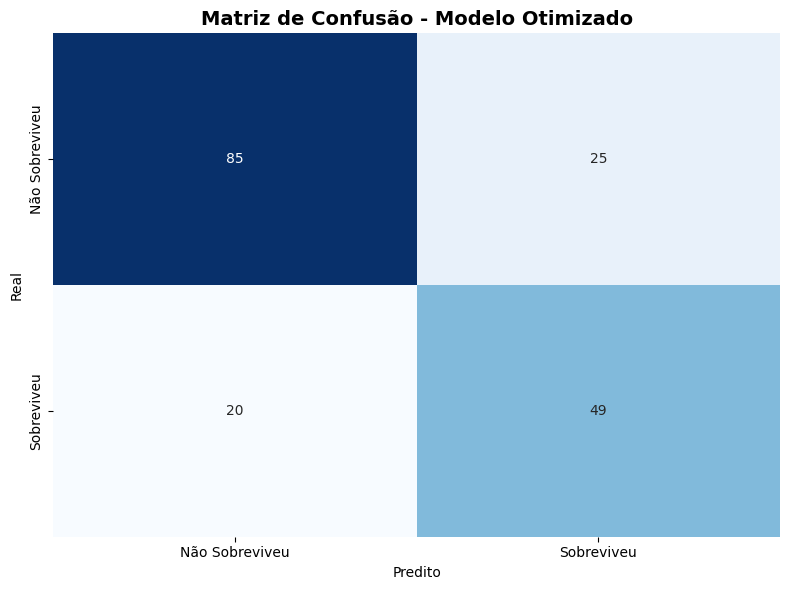

In [134]:
cm = confusion_matrix(y_val, y_val_pred_opt)

print("\n📊 MATRIZ DE CONFUSÃO:")
print("\n             Predito")
print("              0      1")
print(f"Real 0    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"     1    {cm[1,0]:5d}  {cm[1,1]:5d}")

print(f"\nVN (Verdadeiros Negativos): {cm[0,0]}")
print(f"FP (Falsos Positivos):      {cm[0,1]}")
print(f"FN (Falsos Negativos):      {cm[1,0]}")
print(f"VP (Verdadeiros Positivos): {cm[1,1]}")

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title('Matriz de Confusão - Modelo Otimizado', fontsize=14, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.tight_layout()

figures_dir = '../results/figures'
plt.savefig(os.path.join(figures_dir, '07_matriz_confusao.png'), dpi=300, bbox_inches='tight')
print("\n✓ Figura salva: 07_matriz_confusao.png")


 # 6. CURVA ROC E AUC


📊 AUC-ROC: 0.8051
✓ Figura salva: 08_curva_roc.png


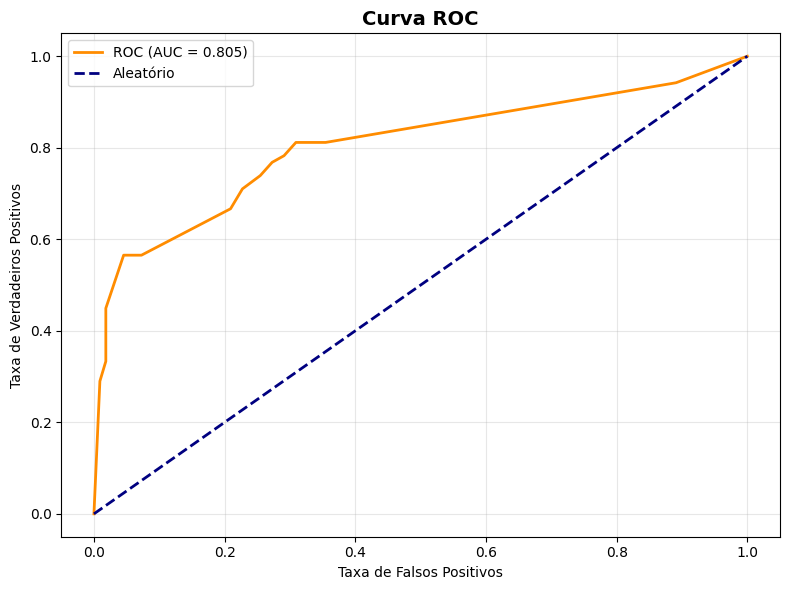

In [135]:
y_val_proba = dt_optimized.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
auc_score = roc_auc_score(y_val, y_val_proba)

print(f"\n📊 AUC-ROC: {auc_score:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '08_curva_roc.png'), dpi=300, bbox_inches='tight')
print("✓ Figura salva: 08_curva_roc.png")


 # 7. IMPORTÂNCIA DAS FEATURES


🏆 TOP 10 FEATURES:
   Sex_encoded         : 0.4754
   Pclass              : 0.1349
   Age                 : 0.1023
   Deck_encoded        : 0.0943
   FarePerPerson       : 0.0782
   Fare                : 0.0726
   FamilySize          : 0.0423
   SibSp               : 0.0000
   Parch               : 0.0000
   IsAlone             : 0.0000

✓ Figura salva: 09_feature_importance.png


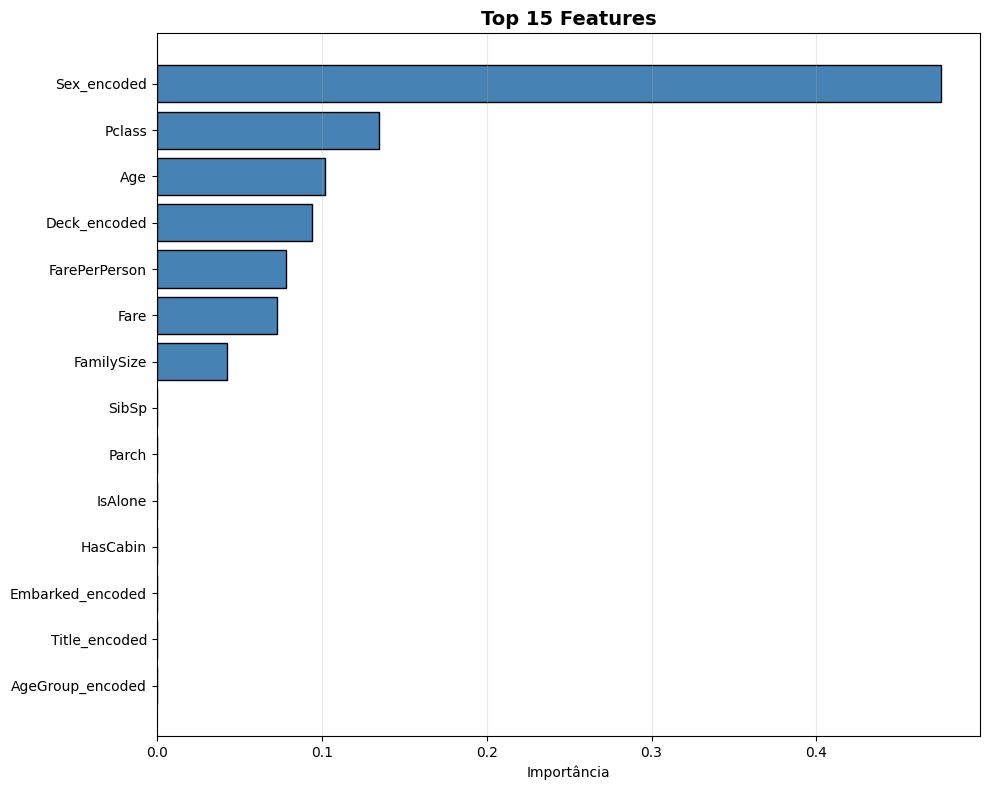

In [136]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_optimized.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🏆 TOP 10 FEATURES:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['Feature']:20s}: {row['Importance']:.4f}")

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importância')
plt.title('Top 15 Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '09_feature_importance.png'), dpi=300, bbox_inches='tight')
print("\n✓ Figura salva: 09_feature_importance.png")


 # 8. VISUALIZAÇÃO DA ÁRVORE


🌳 Gerando visualização...
✓ Árvore completa: 10_arvore_completa.png


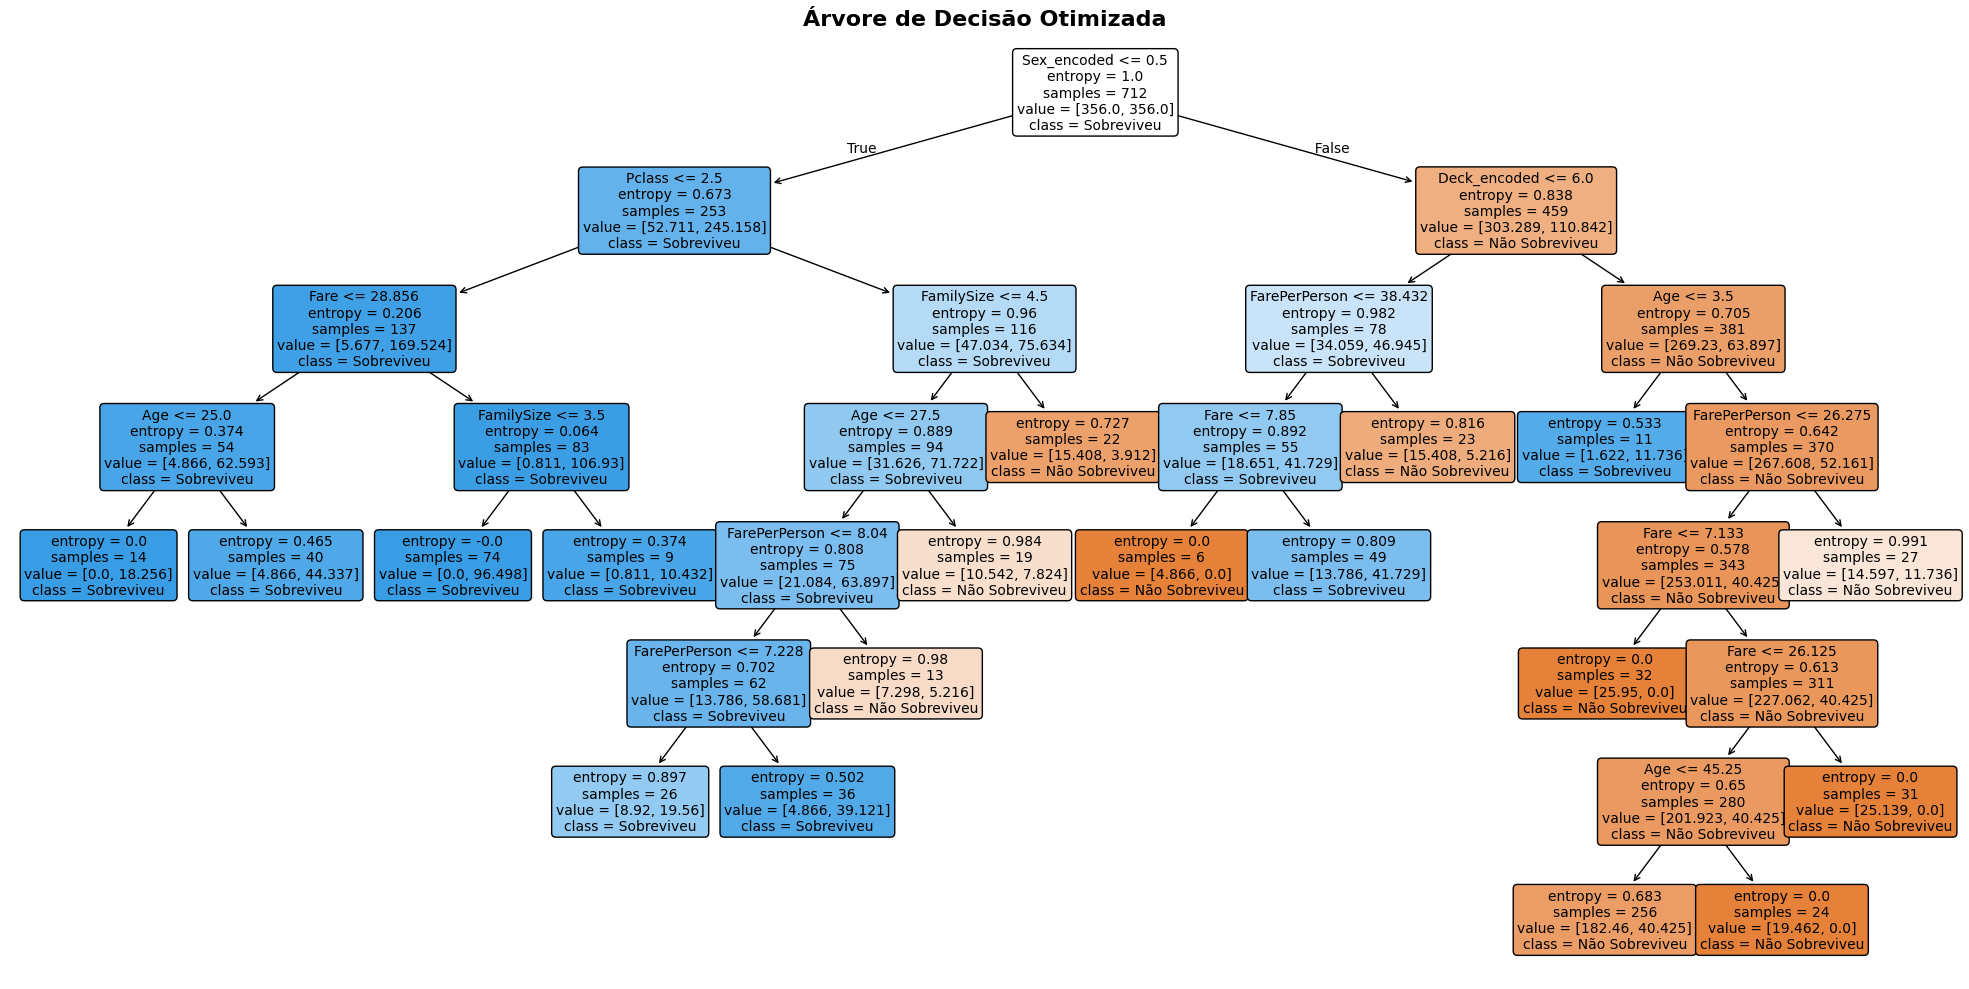

In [137]:
print("\n🌳 Gerando visualização...")

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt_optimized, 
          feature_names=X_train.columns.tolist(),
          class_names=['Não Sobreviveu', 'Sobreviveu'],
          filled=True,
          rounded=True,
          fontsize=10,
          ax=ax)
plt.title('Árvore de Decisão Otimizada', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '10_arvore_completa.png'), dpi=300, bbox_inches='tight')
print("✓ Árvore completa: 10_arvore_completa.png")


✓ Top 3 níveis: 11_arvore_top3.png


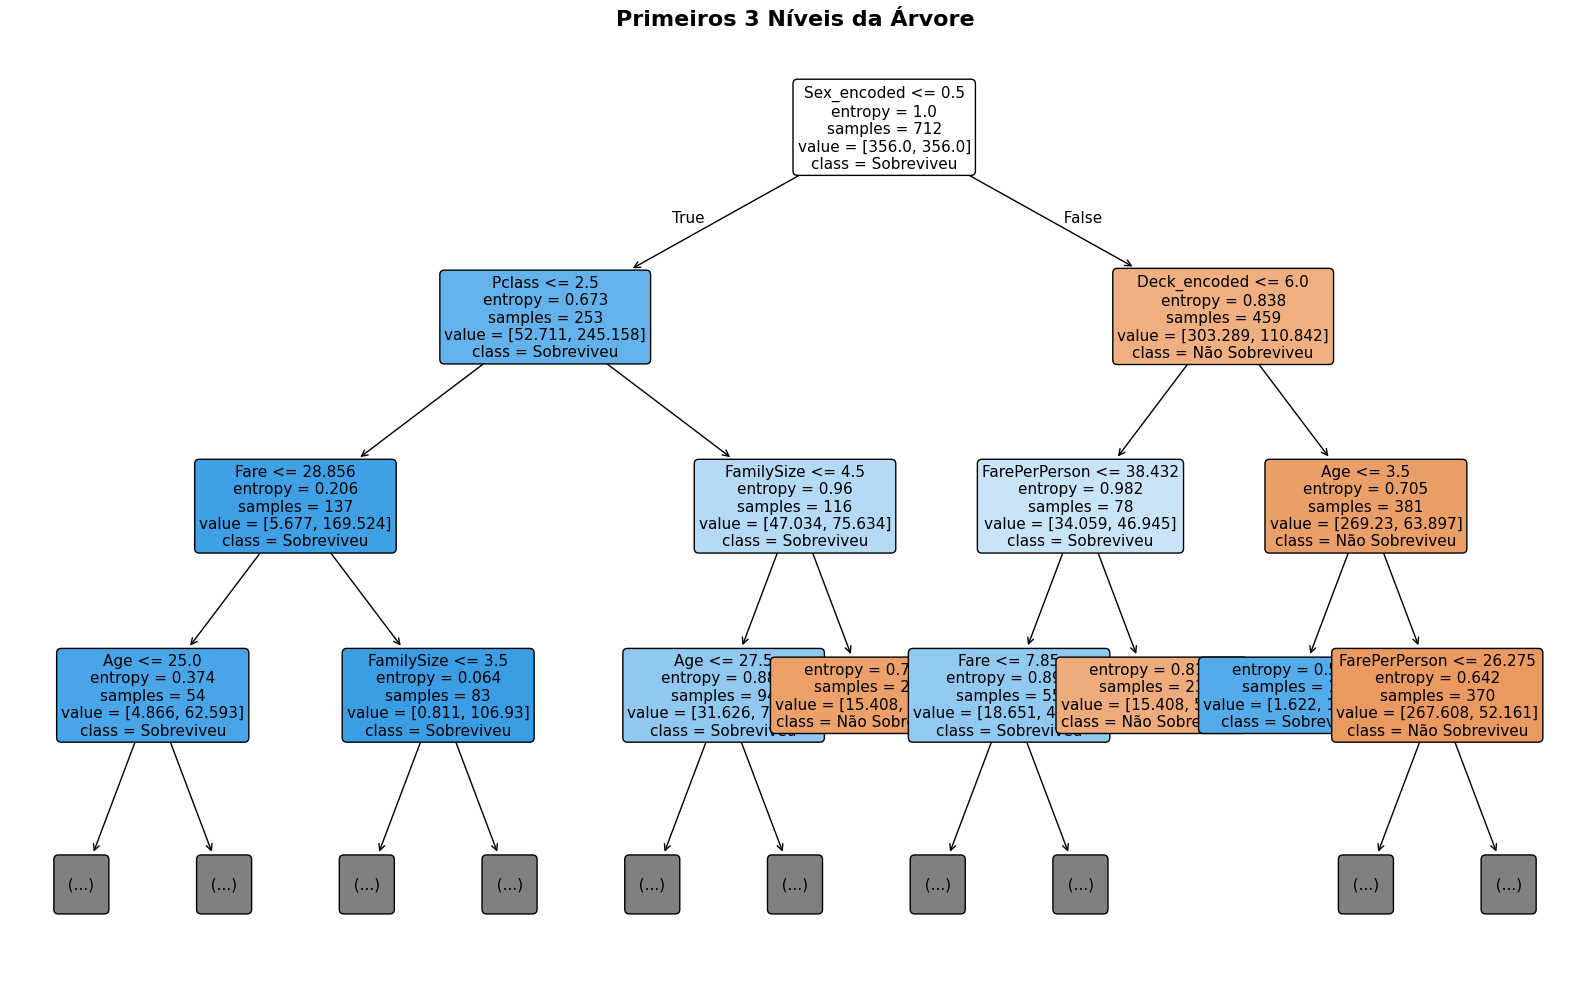

In [138]:
fig, ax = plt.subplots(figsize=(16, 10))
plot_tree(dt_optimized, 
          feature_names=X_train.columns.tolist(),
          class_names=['Não Sobreviveu', 'Sobreviveu'],
          filled=True,
          rounded=True,
          fontsize=11,
          max_depth=3,
          ax=ax)
plt.title('Primeiros 3 Níveis da Árvore', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, '11_arvore_top3.png'), dpi=300, bbox_inches='tight')
print("✓ Top 3 níveis: 11_arvore_top3.png")


 # 9. RANDOM FOREST (COMPARAÇÃO)

In [139]:
# Usa a função com prints de progresso
rf_model, rf_train_scores, rf_val_scores = train_random_forest_with_progress(
    n_estimators=100,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    max_depth=best_params.get('max_depth', 10),
    min_samples_split=best_params.get('min_samples_split', 20),
    min_samples_leaf=best_params.get('min_samples_leaf', 10),
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Informações adicionais após o treinamento
print("\n📊 ESTATÍSTICAS DO RANDOM FOREST:")
print(f"   - Número de árvores: {rf_model.n_estimators}")
print(f"   - Profundidade média das árvores: {np.mean([tree.tree_.max_depth for tree in rf_model.estimators_]):.1f}")
print(f"   - Folhas médias por árvore: {np.mean([tree.tree_.n_leaves for tree in rf_model.estimators_]):.1f}")

# Importância das features (top 5)
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🏆 TOP 5 FEATURES MAIS IMPORTANTES:")
for idx, row in rf_feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']:20s}: {row['Importance']:.4f}")

y_val_pred_rf = rf_model.predict(X_val)

print("\n📊 RANDOM FOREST:")
rf_val = evaluate_model(y_val, y_val_pred_rf, "VALIDAÇÃO")

print("\n📈 COMPARAÇÃO DT vs RF:")
print(f"   {'Métrica':<15} {'DT':<15} {'RF':<15} {'Diferença':<15}")
print("   " + "-" * 60)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    dt_m = opt_val[metric]
    rf_m = rf_val[metric]
    diff = rf_m - dt_m
    print(f"   {metric.capitalize():<15} {dt_m:<15.4f} {rf_m:<15.4f} {diff:+.4f}")



🌲 Treinando Random Forest (100 árvores)...

📊 PROGRESSO DO TREINAMENTO:
Árvore   Acurácia Treino    Acurácia Validação   F1-Score Val   
----------------------------------------------------------------------
1        0.7893             0.7654               0.6957         
2        0.7725             0.7263               0.5505         
3        0.7893             0.7151               0.6277         
4        0.8244             0.7486               0.6400         
5        0.8174             0.7318               0.6418         
10       0.8413             0.7598               0.6815         
20       0.8427             0.7877               0.7286         
30       0.8399             0.7989               0.7500         
40       0.8413             0.7821               0.7347         
50       0.8441             0.7765               0.7260         
60       0.8357             0.7598               0.7034         
70       0.8399             0.7598               0.7075         
80       0.

 # 10. VALIDAÇÃO CRUZADA

In [140]:
print("\n🔄 Cross-Validation - Decision Tree...")

cv_scores_dt = cross_val_score(dt_optimized, X_train, y_train, cv=5, scoring='f1')

print(f"\nF1-Scores por fold:")
for i, score in enumerate(cv_scores_dt, 1):
    print(f"   Fold {i}: {score:.4f}")

print(f"\n📊 Média: {cv_scores_dt.mean():.4f} ± {cv_scores_dt.std():.4f}")



🔄 Cross-Validation - Decision Tree...

F1-Scores por fold:
   Fold 1: 0.7826
   Fold 2: 0.6923
   Fold 3: 0.7788
   Fold 4: 0.8333
   Fold 5: 0.8073

📊 Média: 0.7789 ± 0.0475


In [141]:
print("\n🔄 Cross-Validation - Random Forest...")

cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')

print(f"\nF1-Scores por fold:")
for i, score in enumerate(cv_scores_rf, 1):
    print(f"   Fold {i}: {score:.4f}")

print(f"\n📊 Média: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")



🔄 Cross-Validation - Random Forest...

F1-Scores por fold:
   Fold 1: 0.7395
   Fold 2: 0.7759
   Fold 3: 0.7692
   Fold 4: 0.7869
   Fold 5: 0.7563

📊 Média: 0.7656 ± 0.0164


 # 11. SALVAMENTO

In [142]:
models_dir = '../results/models'
os.makedirs(models_dir, exist_ok=True)

with open(os.path.join(models_dir, 'decision_tree_optimized.pkl'), 'wb') as f:
    pickle.dump(dt_optimized, f)

with open(os.path.join(models_dir, 'random_forest.pkl'), 'wb') as f:
    pickle.dump(rf_model, f)

print("\n💾 Modelos salvos:")
print("   - decision_tree_optimized.pkl")
print("   - random_forest.pkl")



💾 Modelos salvos:
   - decision_tree_optimized.pkl
   - random_forest.pkl


In [143]:
modeling_results = {
    'baseline': {'train': baseline_train, 'val': baseline_val},
    'recommended': {'train': rec_train, 'val': rec_val},
    'optimized': {'train': opt_train, 'val': opt_val},
    'random_forest': {'val': rf_val},
    'best_params': best_params,
    'feature_importance': feature_importance.to_dict(),
    'cv_scores_dt': cv_scores_dt.tolist(),
    'cv_scores_rf': cv_scores_rf.tolist(),
    'auc_score': auc_score,
    'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(models_dir, 'modeling_results.pkl'), 'wb') as f:
    pickle.dump(modeling_results, f)

print("✓ Resultados salvos: modeling_results.pkl")


✓ Resultados salvos: modeling_results.pkl


 # 12. MELHORIAS PARA AUMENTAR ACURÁCIA

 Implementando técnicas avançadas para melhorar o desempenho do modelo


In [144]:
print("\n🚀 INICIANDO MELHORIAS PARA AUMENTAR ACURÁCIA...")
print("=" * 80)

from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

print("\n📊 Estado atual:")
print(f"   - Decision Tree (Otimizado): {opt_val['accuracy']:.4f}")
print(f"   - Random Forest: {rf_val['accuracy']:.4f}")
print(f"   - Meta: > 0.80 (80%)")



🚀 INICIANDO MELHORIAS PARA AUMENTAR ACURÁCIA...

📊 Estado atual:
   - Decision Tree (Otimizado): 0.7486
   - Random Forest: 0.7654
   - Meta: > 0.80 (80%)


 ## 12.1. FEATURE ENGINEERING ADICIONAL

 Criando features interativas baseadas nas features mais importantes


In [145]:
print("\n🔧 Criando features interativas adicionais...")

# Features interativas baseadas nas mais importantes
X_train_enhanced = X_train.copy()
X_val_enhanced = X_val.copy()

# 1. Interação Sex × Pclass (muito importante!)
X_train_enhanced['Sex_Pclass'] = X_train_enhanced['Sex_encoded'] * X_train_enhanced['Pclass']
X_val_enhanced['Sex_Pclass'] = X_val_enhanced['Sex_encoded'] * X_val_enhanced['Pclass']

# 2. Interação Age × Pclass
X_train_enhanced['Age_Pclass'] = X_train_enhanced['Age'] * X_train_enhanced['Pclass']
X_val_enhanced['Age_Pclass'] = X_val_enhanced['Age'] * X_val_enhanced['Pclass']

# 3. Interação Fare × Pclass
X_train_enhanced['Fare_Pclass'] = X_train_enhanced['Fare'] * X_train_enhanced['Pclass']
X_val_enhanced['Fare_Pclass'] = X_val_enhanced['Fare'] * X_val_enhanced['Pclass']

# 4. Interação Sex × Age
X_train_enhanced['Sex_Age'] = X_train_enhanced['Sex_encoded'] * X_train_enhanced['Age']
X_val_enhanced['Sex_Age'] = X_val_enhanced['Sex_encoded'] * X_val_enhanced['Age']

# 5. Interação FamilySize × Pclass
X_train_enhanced['FamilySize_Pclass'] = X_train_enhanced['FamilySize'] * X_train_enhanced['Pclass']
X_val_enhanced['FamilySize_Pclass'] = X_val_enhanced['FamilySize'] * X_val_enhanced['Pclass']

# 6. Categorização de Fare (bins)
X_train_enhanced['FareCategory'] = pd.cut(X_train_enhanced['Fare'], 
                                           bins=[-np.inf, 7.91, 14.45, 31.0, np.inf],
                                           labels=[0, 1, 2, 3])
X_train_enhanced['FareCategory'] = X_train_enhanced['FareCategory'].fillna(1).astype(int)
X_val_enhanced['FareCategory'] = pd.cut(X_val_enhanced['Fare'],
                                        bins=[-np.inf, 7.91, 14.45, 31.0, np.inf],
                                        labels=[0, 1, 2, 3])
X_val_enhanced['FareCategory'] = X_val_enhanced['FareCategory'].fillna(1).astype(int)

# 7. Categorização de Age (bins mais granulares)
X_train_enhanced['AgeCategory'] = pd.cut(X_train_enhanced['Age'],
                                          bins=[0, 12, 18, 35, 60, 100],
                                          labels=[0, 1, 2, 3, 4])
X_train_enhanced['AgeCategory'] = X_train_enhanced['AgeCategory'].fillna(2).astype(int)
X_val_enhanced['AgeCategory'] = pd.cut(X_val_enhanced['Age'],
                                       bins=[0, 12, 18, 35, 60, 100],
                                       labels=[0, 1, 2, 3, 4])
X_val_enhanced['AgeCategory'] = X_val_enhanced['AgeCategory'].fillna(2).astype(int)

print(f"✓ Features criadas: {X_train_enhanced.shape[1] - X_train.shape[1]} novas features")
print(f"   Total de features: {X_train_enhanced.shape[1]}")



🔧 Criando features interativas adicionais...
✓ Features criadas: 7 novas features
   Total de features: 21


 ## 12.2. GRADIENT BOOSTING CLASSIFIER

 Gradient Boosting geralmente oferece melhor desempenho que Random Forest


In [146]:
# Usa a função com prints de progresso
gb_model, gb_train_scores, gb_val_scores = train_gradient_boosting_with_progress(
    n_estimators=200,
    X_train=X_train_enhanced,
    y_train=y_train,
    X_val=X_val_enhanced,
    y_val=y_val,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)

y_val_pred_gb = gb_model.predict(X_val_enhanced)
y_val_proba_gb = gb_model.predict_proba(X_val_enhanced)[:, 1]

print("\n📊 GRADIENT BOOSTING:")
gb_val = evaluate_model(y_val, y_val_pred_gb, "VALIDAÇÃO")

print(f"\n📈 Comparação com modelos anteriores:")
print(f"   {'Modelo':<25} {'Acurácia':<12} {'F1-Score':<12}")
print("   " + "-" * 49)
print(f"   {'Decision Tree':<25} {opt_val['accuracy']:<12.4f} {opt_val['f1']:<12.4f}")
print(f"   {'Random Forest':<25} {rf_val['accuracy']:<12.4f} {rf_val['f1']:<12.4f}")
print(f"   {'Gradient Boosting':<25} {gb_val['accuracy']:<12.4f} {gb_val['f1']:<12.4f}")



🌊 Treinando Gradient Boosting (200 iterações)...

📊 PROGRESSO DO TREINAMENTO:
Iteração   Acurácia Treino    Acurácia Validação   F1-Score Val   
----------------------------------------------------------------------
1          0.6166             0.6145               0.0000         
2          0.7275             0.7039               0.3908         
3          0.8160             0.7654               0.5800         
4          0.8596             0.7933               0.6667         
5          0.8610             0.7933               0.6783         
10         0.8792             0.7877               0.7031         
20         0.8919             0.7933               0.7176         
30         0.9031             0.7989               0.7231         
40         0.9129             0.7989               0.7231         
50         0.9213             0.8156               0.7519         
60         0.9340             0.8212               0.7576         
70         0.9396             0.8156          

 ## 12.3. OTIMIZAÇÃO DE THRESHOLD

 Ajustando o threshold de decisão para maximizar a acurácia


In [147]:
print("\n🎯 Otimizando threshold de decisão...")

from sklearn.metrics import accuracy_score

# Usa o modelo com melhor AUC (Gradient Boosting)
best_proba = y_val_proba_gb.copy()

# Testa diferentes thresholds
thresholds = np.arange(0.3, 0.7, 0.01)
best_threshold = 0.5
best_acc = gb_val['accuracy']

for threshold in thresholds:
    y_pred_thresh = (best_proba >= threshold).astype(int)
    acc = accuracy_score(y_val, y_pred_thresh)
    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

print(f"\n✓ Threshold ótimo encontrado: {best_threshold:.3f}")
print(f"   Acurácia com threshold padrão (0.5): {gb_val['accuracy']:.4f}")
print(f"   Acurácia com threshold ótimo: {best_acc:.4f}")
print(f"   Melhoria: {best_acc - gb_val['accuracy']:+.4f}")

# Aplica threshold otimizado
y_val_pred_gb_opt = (best_proba >= best_threshold).astype(int)
gb_val_opt = evaluate_model(y_val, y_val_pred_gb_opt, "VALIDAÇÃO (Threshold Otimizado)")



🎯 Otimizando threshold de decisão...

✓ Threshold ótimo encontrado: 0.520
   Acurácia com threshold padrão (0.5): 0.8268
   Acurácia com threshold ótimo: 0.8324
   Melhoria: +0.0056

VALIDAÇÃO (Threshold Otimizado):
   - Acurácia:  0.8324
   - Precision: 0.8095
   - Recall:    0.7391
   - F1-Score:  0.7727


 ## 12.4. TUNING AVANÇADO DO RANDOM FOREST

 Otimização mais refinada do Random Forest com RandomizedSearchCV


In [148]:
print("\n🔍 Tuning avançado do Random Forest...")

# Distribuições de parâmetros para RandomizedSearchCV
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': randint(5, 30),
    'min_samples_leaf': randint(2, 15),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

print(f"✓ Espaço de busca configurado")
print(f"   Executando RandomizedSearchCV (20 iterações, 5-fold CV)...")

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train_enhanced, y_train)

print("\n🏆 MELHORES PARÂMETROS (Random Forest):")
for key, value in rf_random.best_params_.items():
    print(f"   - {key}: {value}")

print(f"\n📊 Melhor F1-Score (CV): {rf_random.best_score_:.4f}")

# Avalia no conjunto de validação
rf_tuned = rf_random.best_estimator_
y_val_pred_rf_tuned = rf_tuned.predict(X_val_enhanced)
rf_tuned_val = evaluate_model(y_val, y_val_pred_rf_tuned, "VALIDAÇÃO (RF Tuned)")



🔍 Tuning avançado do Random Forest...
✓ Espaço de busca configurado
   Executando RandomizedSearchCV (20 iterações, 5-fold CV)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🏆 MELHORES PARÂMETROS (Random Forest):
   - class_weight: balanced
   - max_depth: 5
   - max_features: None
   - min_samples_leaf: 6
   - min_samples_split: 14
   - n_estimators: 330

📊 Melhor F1-Score (CV): 0.7812

VALIDAÇÃO (RF Tuned):
   - Acurácia:  0.7877
   - Precision: 0.7246
   - Recall:    0.7246
   - F1-Score:  0.7246


 ## 12.5. GRADIENT BOOSTING COM TUNING

 Otimização do Gradient Boosting também


In [149]:
print("\n🔍 Tuning avançado do Gradient Boosting...")

# Distribuições de parâmetros
gb_param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': randint(10, 30),
    'min_samples_leaf': randint(5, 15),
    'learning_rate': uniform(0.05, 0.15),
    'subsample': uniform(0.7, 0.2)  # entre 0.7 e 0.9
}

print(f"✓ Espaço de busca configurado")
print(f"   Executando RandomizedSearchCV (15 iterações, 5-fold CV)...")

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=15,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

gb_random.fit(X_train_enhanced, y_train)

print("\n🏆 MELHORES PARÂMETROS (Gradient Boosting):")
for key, value in gb_random.best_params_.items():
    print(f"   - {key}: {value:.4f}" if isinstance(value, float) else f"   - {key}: {value}")

print(f"\n📊 Melhor F1-Score (CV): {gb_random.best_score_:.4f}")

# Avalia no conjunto de validação
gb_tuned = gb_random.best_estimator_
y_val_pred_gb_tuned = gb_tuned.predict(X_val_enhanced)
y_val_proba_gb_tuned = gb_tuned.predict_proba(X_val_enhanced)[:, 1]
gb_tuned_val = evaluate_model(y_val, y_val_pred_gb_tuned, "VALIDAÇÃO (GB Tuned)")



🔍 Tuning avançado do Gradient Boosting...
✓ Espaço de busca configurado
   Executando RandomizedSearchCV (15 iterações, 5-fold CV)...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

🏆 MELHORES PARÂMETROS (Gradient Boosting):
   - learning_rate: 0.0748
   - max_depth: 3
   - min_samples_leaf: 11
   - min_samples_split: 18
   - n_estimators: 187
   - subsample: 0.7790

📊 Melhor F1-Score (CV): 0.7660

VALIDAÇÃO (GB Tuned):
   - Acurácia:  0.7933
   - Precision: 0.7424
   - Recall:    0.7101
   - F1-Score:  0.7259


 ## 12.6. ENSEMBLE COM VOTING CLASSIFIER

 Combinando múltiplos modelos para melhor desempenho


In [150]:
print("\n🎭 Criando Ensemble com Voting Classifier...")

# Treina Decision Tree otimizado nas features enhanced
dt_enhanced = DecisionTreeClassifier(**best_params, random_state=42)
dt_enhanced.fit(X_train_enhanced, y_train)

# Cria ensemble com os 3 melhores modelos
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_tuned),
        ('gb', gb_tuned),
        ('dt', dt_enhanced)
    ],
    voting='soft'  # usa probabilidades
)

voting_clf.fit(X_train_enhanced, y_train)
y_val_pred_ensemble = voting_clf.predict(X_val_enhanced)
ensemble_val = evaluate_model(y_val, y_val_pred_ensemble, "VALIDAÇÃO (Ensemble)")

print("\n📈 Comparação dos modelos no ensemble:")
for name, model in voting_clf.named_estimators_.items():
    y_pred = model.predict(X_val_enhanced)
    acc = accuracy_score(y_val, y_pred)
    print(f"   - {name.upper()}: {acc:.4f}")



🎭 Criando Ensemble com Voting Classifier...

VALIDAÇÃO (Ensemble):
   - Acurácia:  0.7877
   - Precision: 0.7460
   - Recall:    0.6812
   - F1-Score:  0.7121

📈 Comparação dos modelos no ensemble:
   - RF: 0.7877
   - GB: 0.7933
   - DT: 0.7486


 ## 12.7. COMPARAÇÃO FINAL DE TODOS OS MODELOS


In [151]:
print("\n" + "=" * 80)
print("COMPARAÇÃO FINAL - TODOS OS MODELOS")
print("=" * 80)

results_comparison = {
    'Decision Tree (Otimizado)': opt_val,
    'Random Forest (Inicial)': rf_val,
    'Gradient Boosting': gb_val,
    'Gradient Boosting (Threshold Otimizado)': gb_val_opt,
    'Random Forest (Tuned)': rf_tuned_val,
    'Gradient Boosting (Tuned)': gb_tuned_val,
    'Ensemble (Voting)': ensemble_val
}

print(f"\n{'Modelo':<40} {'Acurácia':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 88)

for model_name, metrics in sorted(results_comparison.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f"{model_name:<40} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
          f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")

# Identifica o melhor modelo
best_model_name = max(results_comparison.items(), key=lambda x: x[1]['accuracy'])[0]
best_model_metrics = results_comparison[best_model_name]

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"   Acurácia: {best_model_metrics['accuracy']:.4f}")
print(f"   F1-Score: {best_model_metrics['f1']:.4f}")
print(f"   Melhoria sobre baseline: {best_model_metrics['accuracy'] - baseline_val['accuracy']:+.4f}")

# Calcula melhoria percentual
improvement_pct = ((best_model_metrics['accuracy'] - opt_val['accuracy']) / opt_val['accuracy']) * 100
print(f"   Melhoria sobre DT otimizado: {improvement_pct:+.2f}%")



COMPARAÇÃO FINAL - TODOS OS MODELOS

Modelo                                   Acurácia     Precision    Recall       F1-Score    
----------------------------------------------------------------------------------------
Gradient Boosting (Threshold Otimizado)  0.8324       0.8095       0.7391       0.7727      
Gradient Boosting                        0.8268       0.7969       0.7391       0.7669      
Gradient Boosting (Tuned)                0.7933       0.7424       0.7101       0.7259      
Random Forest (Tuned)                    0.7877       0.7246       0.7246       0.7246      
Ensemble (Voting)                        0.7877       0.7460       0.6812       0.7121      
Random Forest (Inicial)                  0.7654       0.6588       0.8116       0.7273      
Decision Tree (Otimizado)                0.7486       0.6622       0.7101       0.6853      

🏆 MELHOR MODELO: Gradient Boosting (Threshold Otimizado)
   Acurácia: 0.8324
   F1-Score: 0.7727
   Melhoria sobre baseline: +0.

 ## 12.8. SALVANDO MODELOS MELHORADOS


In [152]:
print("\n💾 Salvando modelos melhorados...")

# Salva os melhores modelos
with open(os.path.join(models_dir, 'gradient_boosting_tuned.pkl'), 'wb') as f:
    pickle.dump(gb_tuned, f)

with open(os.path.join(models_dir, 'random_forest_tuned.pkl'), 'wb') as f:
    pickle.dump(rf_tuned, f)

with open(os.path.join(models_dir, 'ensemble_voting.pkl'), 'wb') as f:
    pickle.dump(voting_clf, f)

print("✓ Modelos salvos:")
print("   - gradient_boosting_tuned.pkl")
print("   - random_forest_tuned.pkl")
print("   - ensemble_voting.pkl")

# Atualiza resultados
enhanced_results = {
    'original_results': modeling_results,
    'enhanced_features_count': X_train_enhanced.shape[1],
    'new_features': ['Sex_Pclass', 'Age_Pclass', 'Fare_Pclass', 'Sex_Age', 
                     'FamilySize_Pclass', 'FareCategory', 'AgeCategory'],
    'all_models_comparison': results_comparison,
    'best_model': best_model_name,
    'best_threshold': best_threshold,
    'improvement_over_baseline': best_model_metrics['accuracy'] - baseline_val['accuracy'],
    'improvement_pct': improvement_pct,
    'date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(models_dir, 'enhanced_modeling_results.pkl'), 'wb') as f:
    pickle.dump(enhanced_results, f)

print("✓ Resultados melhorados salvos: enhanced_modeling_results.pkl")



💾 Salvando modelos melhorados...
✓ Modelos salvos:
   - gradient_boosting_tuned.pkl
   - random_forest_tuned.pkl
   - ensemble_voting.pkl
✓ Resultados melhorados salvos: enhanced_modeling_results.pkl
